# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [1]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [2]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


In [5]:
type(speeches_201718['party'])

pandas.core.series.Series

Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [3]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [4]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

When the two Barplots representing the Number of Speeches made by each party, party "S" and "M" have highest number of speeches in both election. Holistically comparing both the plots its evident that the Number of SPeeches has increased considerbaly in 2018 election.

In [5]:
# Counting the number of speeches in each year
# 2017-2018
count17 = speeches_201718.groupby(['party']).size().reset_index()
count17.rename(columns={0: 'count'}, inplace=True)

# 2018-2019
count18 = speeches_201819.groupby(['party']).size().reset_index()
count18.rename(columns={0: 'count'}, inplace=True)

In [6]:
import matplotlib.pyplot as plot
count17.plot.bar(x="party", y="count", rot=70, title="Number of speeches - Year 2017");
count17.plot.bar(x="party", y="count", rot=70, title="Number of speeches - Year 2018",color='orange');

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('cvect', CountVectorizer()),('mnb', MultinomialNB())])

fitted_pipe=pipe.fit(training_data['words'], training_data['party'])

party_pred = fitted_pipe.predict(test_data['words'])

In [8]:
from sklearn import metrics
print(metrics.classification_report(test_data['party'], party_pred,    
                                    target_names=parties))

              precision    recall  f1-score   support

           C       0.63      0.04      0.07       671
          KD       0.70      0.02      0.03       821
           L       0.92      0.02      0.04       560
           M       0.36      0.68      0.47      1644
          MP       0.36      0.25      0.29       809
           S       0.46      0.84      0.59      2773
          SD       0.57      0.12      0.20      1060
           V       0.59      0.15      0.24       950

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



Would you have expected the results that you got?

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [9]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(training_data['words'], training_data['party'])
party_dummy_pred = dummy_clf.predict(test_data)

print(metrics.classification_report(test_data['party'], party_dummy_pred,    
                                    target_names=parties))

              precision    recall  f1-score   support

           C       0.07      0.13      0.09       671
          KD       0.09      0.13      0.10       821
           L       0.07      0.14      0.09       560
           M       0.17      0.11      0.13      1644
          MP       0.09      0.12      0.10       809
           S       0.31      0.13      0.18      2773
          SD       0.12      0.13      0.13      1060
           V       0.09      0.12      0.11       950

    accuracy                           0.12      9288
   macro avg       0.13      0.13      0.12      9288
weighted avg       0.17      0.12      0.13      9288



An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [23]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(training_data['words'], training_data['party'])
party_dummy_pred = dummy_clf.predict(test_data)

print("The Prediction score is found to be:",dummy_clf.score(test_data['words'],test_data['party']))

print(metrics.classification_report(test_data['party'], party_dummy_pred,    
                                    target_names=parties))

The Prediction score is found to be: 0.298557278208441
              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.00      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.04      0.12      0.06      9288
weighted avg       0.09      0.30      0.14      9288



## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Discuss your findings in a short text. Would you argue that undersampling make sense for the task of predicting the party of a speaker?

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [11]:
g = training_data.groupby('party')
bal_training_data = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

bal_pipe=pipe.fit(bal_training_data['words'], bal_training_data['party'])

bal_party_pred = bal_pipe.predict(test_data['words'])
print(metrics.classification_report(test_data['party'], bal_party_pred,    
                                    target_names=parties))

              precision    recall  f1-score   support

           C       0.29      0.45      0.36       671
          KD       0.29      0.40      0.34       821
           L       0.25      0.45      0.33       560
           M       0.43      0.48      0.45      1644
          MP       0.35      0.41      0.38       809
           S       0.81      0.28      0.42      2773
          SD       0.46      0.41      0.43      1060
           V       0.38      0.57      0.45       950

    accuracy                           0.40      9288
   macro avg       0.41      0.43      0.39      9288
weighted avg       0.50      0.40      0.41      9288



*TODO: Enter your answer here*

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_data['party'],bal_party_pred,labels = parties)

array([[302,  65,  51,  97,  43,  12,  42,  59],
       [ 76, 331,  61, 150,  43,  23,  62,  75],
       [ 59,  46, 252,  60,  25,   9,  39,  70],
       [182, 191, 149, 781,  89,  40, 106, 106],
       [ 63,  74,  70,  66, 335,  68,  34,  99],
       [198, 259, 216, 422, 338, 779, 178, 383],
       [ 93,  97, 123, 145,  39,  20, 439, 104],
       [ 53,  74,  68, 109,  38,   8,  60, 540]], dtype=int64)

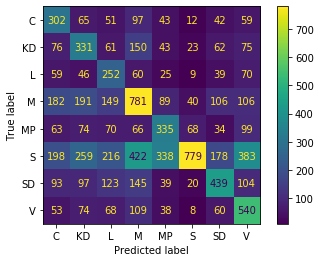

In [12]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(bal_pipe, test_data['words'],test_data['party'],labels=parties)  
plot.show()

Take a minute to reflect on the question whether your results make sense.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. (Why would that be a bad idea?) Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [18]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

vectorizer = CountVectorizer()
pipe = Pipeline([('countvectorizer', vectorizer),('MNBC',MultinomialNB())])
parameters = dict(countvectorizer__binary = [True,False],
    countvectorizer__ngram_range=[(1, 1), (1, 2)],
                 MNBC__alpha = [1,0.1])
#parameters = dict(
#    countvectorizer__ngram_range=[(1, 1), (1, 2)],
#                 MNBC__alpha = [1,0.1])
clf = GridSearchCV(pipe, parameters)
clf.fit(bal_training_data['words'],bal_training_data['party'])
pred = clf.predict(test_data['words'])
print(classification_report(test_data['party'],pred, target_names=parties))

              precision    recall  f1-score   support

           C       0.32      0.46      0.38       671
          KD       0.34      0.39      0.36       821
           L       0.27      0.46      0.34       560
           M       0.46      0.46      0.46      1644
          MP       0.33      0.47      0.39       809
           S       0.77      0.42      0.54      2773
          SD       0.50      0.45      0.47      1060
           V       0.46      0.59      0.52       950

    accuracy                           0.45      9288
   macro avg       0.43      0.46      0.43      9288
weighted avg       0.51      0.45      0.46      9288



## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model. Did you manage to get better results than the ones that you obtained in Problem&nbsp;6? Answer with a short text.

In [19]:
from sklearn.tree import DecisionTreeClassifier


vectorizer = CountVectorizer()
pipe = Pipeline([('countvectorizer', vectorizer),('decisiontree',DecisionTreeClassifier(max_depth=5))])
tuned_parameters = dict(countvectorizer__binary = [True,False],decisiontree__max_depth = [10,20,30,40,50,60],
    decisiontree__max_features = ['sqrt', 'log2', None])

clf = GridSearchCV(pipe, tuned_parameters)

In [20]:
clf.fit(bal_training_data['words'],bal_training_data['party'])
#Pipeline([('countvectorizer', vectorizer),('MNBC',MultinomialNB())])
pred = clf.predict(test_data['words'])
print(classification_report(test_data['party'],pred, target_names=parties))

              precision    recall  f1-score   support

           C       0.41      0.42      0.41       671
          KD       0.40      0.33      0.36       821
           L       0.42      0.34      0.37       560
           M       0.49      0.27      0.34      1644
          MP       0.12      0.61      0.20       809
           S       0.53      0.15      0.24      2773
          SD       0.37      0.26      0.31      1060
           V       0.30      0.30      0.30       950

    accuracy                           0.29      9288
   macro avg       0.38      0.33      0.32      9288
weighted avg       0.42      0.29      0.30      9288



In [21]:
clf.best_params_

{'countvectorizer__binary': True,
 'decisiontree__max_depth': 20,
 'decisiontree__max_features': None}

The results where not satisfcatory when the data is fit with Decision Tree classifier. The accuracy is dropped to 0.32, where as the model fitted with MNB has an accuracy of 0.45, which is so far the best model.

<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>